# Plotting Bathymetric Data in Python

In [1]:
import seaborn as sns 
import numpy as np
import datetime
import rasterio as rio
import earthpy as et
import earthpy.plot as ep
import scipy
import scipy.signal
from matplotlib import pyplot as plt 
from PIL import Image

## Notes on Parsing Bathymetric Data
- TIF files have helpful meta data encoded in them, such as WGS84 UTM grids: https://www.spatialreference.org/ref/epsg/4326/

## Helper Functions 

In [2]:
def archaversine(lat1, lat2, lon1, lon2):
    DEG_TO_RAD = np.pi/180
    lat1 = lat1*DEG_TO_RAD
    lat2 = lat2*DEG_TO_RAD
    lon1 = lon1*DEG_TO_RAD
    lon2 = lon2*DEG_TO_RAD
    R = 6371000
    return(2*R*np.arcsin(((np.sin((lat2-lat1)/2)**2) + 
                           np.cos(lat1)*np.cos(lat2)*(np.sin((lon2-lon1)/2)**2))**0.5))

## Process Environment Data

In [163]:
##################################################
# Kolumbo Data 
Kolumbo = {
    'file'  : "/Users/zduguid/Dropbox (MIT)/MIT-WHOI/Kolumbo cruise 2019/Grids/kolumbo bathymetry.tif",
    'AR'    : True,
    'crop'  : None,
    'title' : 'Kolumbo Volcano, Santorini, Greece',
    'xlabel': 'Longitude [deg]',
    'ylabel': 'Latitude [deg]',
    'ticks' : '%.3f',
    'slope_max' : None
}


# Buzzards Bay data 
BuzzardsBay = {
    'file'  : "/Users/zduguid/Downloads/BuzzBay_10m/BuzzBay_10m.tif",
    'AR'    : False,
    'crop'  : [1500, 5740, 1500, 6200],
        # crop  = [top, bot, left, right]
        # bathy = bathy_im[top:bot, left:right]
    'title' : 'Buzzards Bay, MA',
    'xlabel': 'UTM Zone 19',
    'ylabel': '',
    'ticks' : '%.2g',
    'slope_max' : 8,
    'meta'  : {
        'utm_zone' : 19,
        'coordinate_system' : 'North American Datum of 1983 and the North American Vertical Datum of 1988',
        'link' : 'https://www.sciencebase.gov/catalog/item/5a4649b8e4b0d05ee8c05486'
    }
}

In [164]:
##################################################
# select data file for processing
# data = Kolumbo
data = BuzzardsBay

# Constants 
RAD_TO_DEG = 180/np.pi

# open and parse the bathy file
with rio.open(data['file']) as bathy_dem:
    bathy_meta      = bathy_dem.meta
    bathy_im_h      = bathy_dem.height
    bathy_im_w      = bathy_dem.width
    bathy_im        = bathy_dem.read()[0]
    bathy_nodata    = bathy_dem.meta['nodata']
    bathy_bounds    = bathy_dem.bounds
    delta_x,delta_y = bathy_dem.res
    print(bathy_meta)
#     print(bathy_dem.bounds)
#     print(bathy_dem.res)
#     print(bathy_dem.tags(ns="IMAGE_STRUCTURE"))
#     print(bathy_dem.crs.data)
#     print(et.epsg[bathy_dem.crs.data['init'].split(':')[-1]])
    
# filter out no data value from the array
bathy_im[bathy_im==bathy_nodata] = np.NaN
bathy_im[bathy_im>0] = np.NaN


##################################################
# crop data if bounds specified
if data['crop']:
    # TODO be careful if cropping and fixing AR
    # TODO be careful if cropping bounds too big
    top, bot, left, right = data['crop']
    bathy    = np.copy(bathy_im[top:bot, left:right])
    _l, _r   = bathy_bounds.left, bathy_bounds.right
    _t, _b   = bathy_bounds.top,  bathy_bounds.bottom
    # new array width after cropping 
    bathy_w  = right - left
    bathy_h  = bot   - top
    bathy_l  = _l +  (left/bathy_im_w)*(_r - _l)
    bathy_r  = _l + (right/bathy_im_w)*(_r - _l)
    bathy_b  = _t +   (bot/bathy_im_h)*(_b - _t)
    bathy_t  = _t +   (top/bathy_im_h)*(_t - _b)

# resize the bathy image
if data['AR']:
    bathy_l = bathy_bounds.left
    bathy_r = bathy_bounds.right
    bathy_t = bathy_bounds.top
    bathy_b = bathy_bounds.bottom
    range_y = archaversine(bathy_t, bathy_b, bathy_l, bathy_l)
    range_x = archaversine(bathy_t, bathy_t, bathy_l, bathy_r)
    bathy_w = int(np.round((bathy_im_h + (range_x/range_y)*bathy_im_w) / (range_y/range_x + range_x/range_y)))
    bathy_h = int(np.round((range_y/range_x)*bathy_w))
    bathy   = np.array(Image.fromarray(bathy_im).resize((bathy_w,bathy_h)))
    delta_x, delta_y = range_x/bathy_w, range_y/bathy_h

    
##################################################
# Scharr operator for computing gradients
scharr = np.array([[ -3 -3j, -10+0j, -3 +3j],
                   [ 0 -10j,  0+ 0j,  0+10j],
                   [ +3 -3j, +10+0j, +3 +3j]]) / 32  # Gx + j*Gy

# compute gradient, slope, and orientation using convolution 
bathy_grad   = scipy.signal.convolve2d(bathy, scharr, boundary='symm', mode='same')/(np.max([delta_x,delta_y]))
bathy_slope  = np.arctan(np.absolute(bathy_grad))*RAD_TO_DEG
bathy_orient = np.angle(bathy_grad)*-RAD_TO_DEG

# # filter slope data if required 
# if data['slope_max']:
#     bathy_slope[bathy_slope > data['slope_max']] = data['slope_max']
    
print('>> Parsing Complete')

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 6753, 'height': 5740, 'count': 1, 'crs': CRS.from_epsg(26919), 'transform': Affine(10.0, 0.0, 304499.03419999965,
       0.0, -10.0, 4637993.826199999)}


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater


>> Parsing Complete


## Plot Environment Data

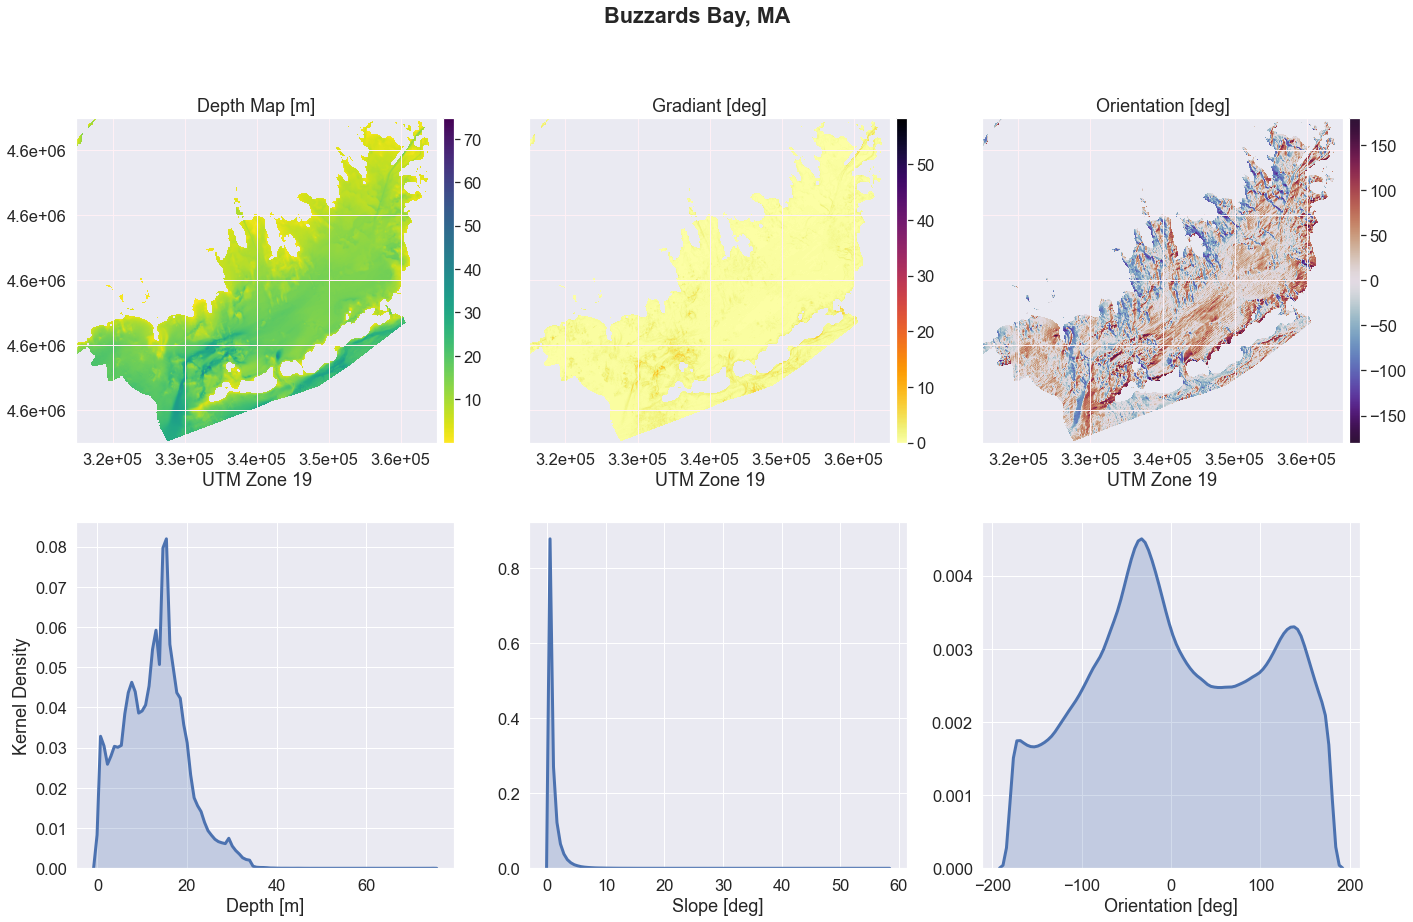

In [165]:
sns.set(font_scale = 1.5)
# fig, ax = plt.subplots(2,3, figsize=(23,6))
fig, ax = plt.subplots(2,3, figsize=(23,14))
plt.suptitle(data['title'], fontweight='bold')


# plot seafloor depth
ep.plot_bands(
    -bathy, 
    cmap='viridis_r',
    title="Depth Map [m]",
    ax=ax[0,0],
    scale=False
)


# plot seafloor slope
ep.plot_bands(
    bathy_slope, 
    cmap='inferno_r',
    title='Gradiant [deg]',
    ax=ax[0,1],
    scale=False
)


# plot seafloor slope orientation 
ep.plot_bands(
    bathy_orient, 
    cmap='twilight_shifted',
    title='Orientation [deg]',
    ax=ax[0,2],
    scale=False
)


sns.kdeplot(-bathy.flatten(),       shade=True, ax=ax[1,0], linewidth=3)
sns.kdeplot(bathy_slope.flatten(),  shade=True, ax=ax[1,1], linewidth=3)
sns.kdeplot(bathy_orient.flatten(), shade=True, ax=ax[1,2], linewidth=3)
ax[1,0].set_xlabel('Depth [m]')
ax[1,1].set_xlabel('Slope [deg]')
ax[1,2].set_xlabel('Orientation [deg]')
num_ticks = 5
xticks  = np.arange(bathy_w/num_ticks/2, bathy_w, bathy_w/num_ticks)
xlabels = [data['ticks'] % np.round((bathy_r-bathy_l)*(i/bathy_w) + bathy_l, 3) for i in xticks]
yticks  = np.arange(bathy_h/num_ticks/2, bathy_h, bathy_h/num_ticks)
ylabels = [data['ticks'] % np.round((bathy_t-bathy_b)*(i/bathy_h) + bathy_b, 3) for i in yticks]


# plot axis labels 
for i in range(3):
    ax[0,i].set_xticks(xticks)
    ax[0,i].set_xticklabels(xlabels)
    ax[0,i].set_yticks(yticks)
    if i==0:
        ax[0,i].set_yticklabels(ylabels)
        ax[0,i].set_ylabel(data['ylabel'])
        ax[1,i].set_ylabel('Kernel Density')
    else:
        ax[0,i].set_yticklabels(['' for _ in ylabels])
    ax[0,i].set_xlabel(data['xlabel'])
    ax[0,i].grid(linewidth=1, alpha=1, color='lavenderblush')
plt.savefig('/Users/zduguid/Desktop/fig/BuzzardsBay-original.png')

plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


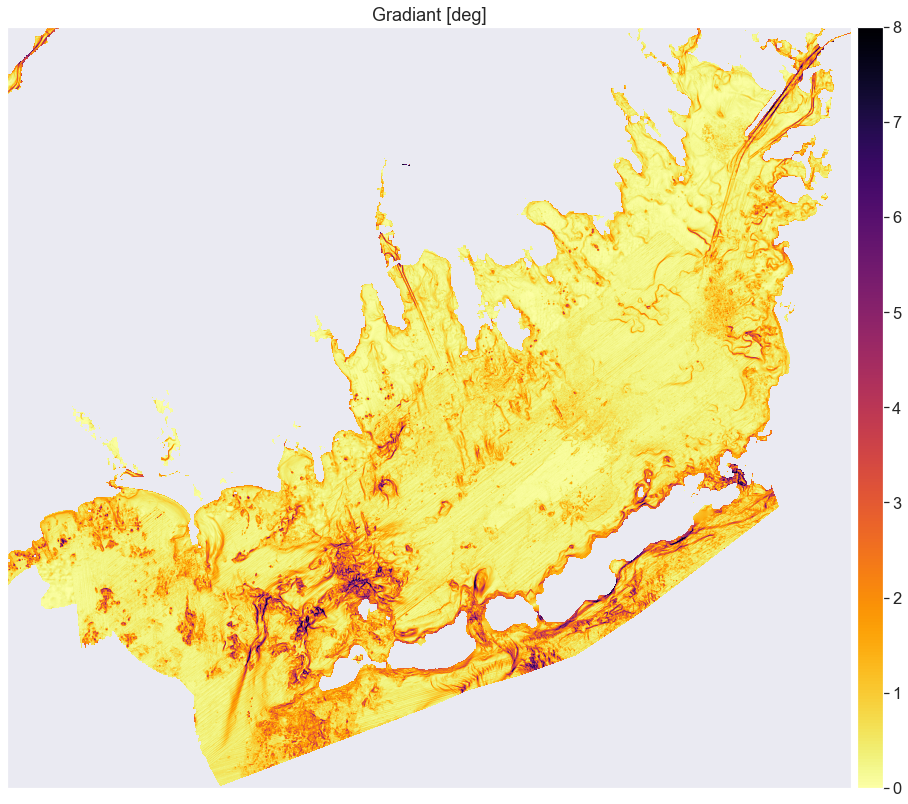

In [152]:
fig, ax = plt.subplots(figsize=(23,14))

slope_max = 8
test = np.copy(bathy_slope)
test[test>slope_max] = slope_max

# plot seafloor slope
bathy_plot = ep.plot_bands(
    test, 
    cmap='inferno_r',
    title='Gradiant [deg]',
    ax=ax,
    scale=False
)
plt.show()
# plt.show()



In [129]:
test = np.copy(bathy_slope)
test[test>5] = np.NaN
print(np.nanmax(test))

4.99999938911396


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
